In [1]:
#load libraries
import os
import glob
from eumap import parallel
from eumap.parallel import TilingProcessing
from eumap.raster import read_rasters, save_rasters
from eumap.misc import ttprint
from eumap.misc import find_files
import re
import pandas as pd
import numpy as np
import rasterio
from pathlib import Path
from osgeo import gdal
import geopandas as gpd
import matplotlib.pyplot as plt
import random
from shapely.geometry import Polygon, Point
from eumap.mapper import SpaceOverlay
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib
from eumap.mapper import LandMapper
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from random import sample
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GridSearchCV#
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV
from scipy.stats import uniform, randint
import joblib

In [3]:
#save to file
outpath = 'melted_sp_overlay_trgpts_fapar_v20230918.lz4'
df_melted = joblib.load(outpath)

In [4]:
#add sample weights of strata as column
weight_csv = pd.read_csv('std_hp_strata_v20230821.csv')

In [5]:
weight_csv["sample_weight"] = 1/(weight_csv["n_samples_incl_min200"]/weight_csv["size"])
weight_csv

,Unnamed: 0,stratum,size,std,n_samples_incl_min200,sample_weight
0,0,1,23517852472,72.015284,7738.0,3.039268e+06
1,1,2,13870136,70.292143,204.0,6.799086e+04
2,2,3,174111464,60.174584,247.0,7.049047e+05
3,3,4,11797016,58.520642,203.0,5.811338e+04
4,4,5,163219120,59.303263,243.0,6.716836e+05
5,5,7,529097288,53.979623,327.0,1.618035e+06
6,6,9,3092984,50.649545,201.0,1.538798e+04
7,7,11,2689992,48.406093,201.0,1.338304e+04
8,9,13,270521584,55.274607,267.0,1.013189e+06
9,11,15,1914936,52.322790,200.0,9.574680e+03


In [6]:
df_weights_pre = pd.merge(df_melted, weight_csv[["stratum", "sample_weight"]], on="stratum", how="left")
df_weights_pre

,hfp,pop_count,bio10,bio11,bio12,bio13,bio14,bio15,bio16,bio17,...,stratum,diff_tasactual_longterm,diff_practual_longterm,fapar_p95_smooth,wv_yearly_p25,wv_yearly_p50,wv_yearly_p75,fapar_q,fapar_value,sample_weight
0,20.0,0.0,2902.0,2684.0,6682.0,981.0,362.0,371.0,2611.0,1103.0,...,1,-3.399994,-380.0,145.0,539.0,1007.0,1424.0,50,120.0,3.039268e+06
1,18.0,0.0,2995.0,2838.0,17029.0,1803.0,947.0,169.0,5059.0,3396.0,...,1,0.699982,472.0,162.0,1121.0,1586.0,2676.0,50,155.0,3.039268e+06
2,26.0,75.0,2900.0,2776.0,9221.0,991.0,604.0,164.0,2893.0,1900.0,...,1,-0.100006,-835.0,168.0,949.0,1217.0,2101.0,50,158.0,3.039268e+06
3,21.0,0.0,3042.0,2973.0,3761.0,1146.0,0.0,1260.0,2815.0,0.0,...,1,-0.399994,35.0,12.0,1164.0,1435.0,2596.0,50,12.0,3.039268e+06
4,7.0,0.0,3020.0,2855.0,4624.0,1040.0,45.0,814.0,2536.0,275.0,...,1,-1.5,127.0,18.0,657.0,790.0,1545.0,50,15.0,3.039268e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10723180,0.0,0.0,2787.0,2409.0,3813.0,747.0,99.0,658.0,1852.0,326.0,...,18,-0.699997,-746.0,0.0,376.0,613.0,715.0,95,0.0,2.701686e+06
10723181,0.0,0.0,2885.0,2602.0,7047.0,898.0,336.0,312.0,2528.0,1051.0,...,18,-6.899994,-2332.0,115.0,457.0,646.0,1365.0,95,115.0,2.701686e+06
10723182,0.0,0.0,3081.0,2909.0,370.0,114.0,0.0,1151.0,245.0,10.0,...,18,-2.600006,31.0,0.0,1303.0,1439.0,1583.0,95,0.0,2.701686e+06
10723183,0.0,0.0,3069.0,2907.0,347.0,93.0,5.0,1009.0,216.0,25.0,...,18,-0.699982,15.0,0.0,1146.0,1804.0,2130.0,95,0.0,2.701686e+06


In [ ]:
#draw random subsamples of IDs of each stratum of exactly the number of samples needed for min200 that will be used further
strata_ls = list(weight_csv.stratum)

random.seed(123)
ids_to_keep = []
for i in strata_ls:
    print(i)
    df_weights_i = df_weights_pre[df_weights_pre['stratum'] == i]
    id_ls = list(np.unique(df_weights_i.id))
    n_samples=weight_csv.loc[weight_csv['stratum'] == i, 'n_samples_incl_min200']
    print(n_samples)
    sampled_ids = random.sample(id_ls, int(n_samples.values[0]))
    ids_to_keep.extend(sampled_ids)
    print(len(ids_to_keep))

In [8]:
df_weights = df_weights_pre[df_weights_pre["id"].isin(ids_to_keep)]

In [10]:
df_weights_scaled = df_weights.copy()
df_weights_scaled["fapar_value_scaled"] = df_weights_scaled["fapar_value"] * 0.004
df_weights_scaled.drop(["fapar_value"], axis=1, inplace=True)
df_weights_scaled.rename(columns={"fapar_value_scaled": "fapar_value"}, inplace=True)
df_weights_scaled

,hfp,pop_count,bio10,bio11,bio12,bio13,bio14,bio15,bio16,bio17,...,stratum,diff_tasactual_longterm,diff_practual_longterm,fapar_p95_smooth,wv_yearly_p25,wv_yearly_p50,wv_yearly_p75,fapar_q,sample_weight,fapar_value
0,20.0,0.0,2902.0,2684.0,6682.0,981.0,362.0,371.0,2611.0,1103.0,...,1,-3.399994,-380.0,145.0,539.0,1007.0,1424.0,50,3.039268e+06,0.48
1,18.0,0.0,2995.0,2838.0,17029.0,1803.0,947.0,169.0,5059.0,3396.0,...,1,0.699982,472.0,162.0,1121.0,1586.0,2676.0,50,3.039268e+06,0.62
2,26.0,75.0,2900.0,2776.0,9221.0,991.0,604.0,164.0,2893.0,1900.0,...,1,-0.100006,-835.0,168.0,949.0,1217.0,2101.0,50,3.039268e+06,0.632
3,21.0,0.0,3042.0,2973.0,3761.0,1146.0,0.0,1260.0,2815.0,0.0,...,1,-0.399994,35.0,12.0,1164.0,1435.0,2596.0,50,3.039268e+06,0.048
4,7.0,0.0,3020.0,2855.0,4624.0,1040.0,45.0,814.0,2536.0,275.0,...,1,-1.5,127.0,18.0,657.0,790.0,1545.0,50,3.039268e+06,0.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10723180,0.0,0.0,2787.0,2409.0,3813.0,747.0,99.0,658.0,1852.0,326.0,...,18,-0.699997,-746.0,0.0,376.0,613.0,715.0,95,2.701686e+06,0.0
10723181,0.0,0.0,2885.0,2602.0,7047.0,898.0,336.0,312.0,2528.0,1051.0,...,18,-6.899994,-2332.0,115.0,457.0,646.0,1365.0,95,2.701686e+06,0.46
10723182,0.0,0.0,3081.0,2909.0,370.0,114.0,0.0,1151.0,245.0,10.0,...,18,-2.600006,31.0,0.0,1303.0,1439.0,1583.0,95,2.701686e+06,0.0
10723183,0.0,0.0,3069.0,2907.0,347.0,93.0,5.0,1009.0,216.0,25.0,...,18,-0.699982,15.0,0.0,1146.0,1804.0,2130.0,95,2.701686e+06,0.0


In [12]:
outpath = 'melted_sp_overlay_trgpts_fapar_12500_v20230918.lz4'
# joblib.dump(df_weights_scaled, outpath, compress=True)

['/mnt/freya/julia/potential_fapar/data/overlay/sp_overlay_12500trgpts_strata_covs_and_fapar_and_wv_faparwhit_scaled_v20230821.lz4']

In [79]:
#save points as geopackage again
#keep only one point per id
trg_pnts_final = df_weights_scaled.drop_duplicates(subset=["id"], keep='first')

In [ ]:
import geopandas
tgr_pnts_epsg4326 = geopandas.GeoDataFrame(
    trg_pnts_final, geometry=geopandas.points_from_xy(x=trg_pnts_final.lon, y=trg_pnts_final.lat, crs="+proj=longlat +datum=WGS84 +no_defs +type=crs")
)
tgr_pnts_epsg4326

# tgr_pnts_epsg4326.to_file(f'../data/training_pts/trgpts_fapar_12500_v20230918.gpkg',  driver="GPKG")

In [ ]:
#get random subsample for RFE
id_ls = list(np.unique(df_weights_scaled.id))
print(len(id_ls))

#random subsample of 3700 values from id list  (makes 3mio data rows)
random.seed(123)
sample_ids = random.sample(id_ls, 4000)
df_melted_rfe_subset = df_weights_scaled[df_weights_scaled["id"].isin(sample_ids)]
print(len(df_melted_rfe_subset))

# check if all strata covered then
for i in list(np.unique(df_weights_scaled.stratum)):
    numbers_pnts = len(np.unique(df_melted_rfe_subset[df_melted_rfe_subset["stratum"]==i]["id"]))
    print(i, numbers_pnts, "proportion:", numbers_pnts/len(df_melted_rfe_subset))

df_rfecv = df_melted_rfe_subset.copy()
df_rfecv

In [31]:
from sklearn.model_selection import GroupKFold, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV, RFE
from sklearn.model_selection import GridSearchCV
from scipy.signal import argrelmin
import joblib
import multiprocessing

#input data

samples = df_rfecv  #df_weights[:100]
samples_cols = list(samples.columns)
cols_to_drop = ['lat', 'lon', 'id', 'year', 'fapar_value', 'stratum', 'sample_weight', "wetland_ind", "flood_hazard", "month", "fapar_p95_smooth", "wv_yearly_p75","wv_yearly_p25", "wv_yearly_p50", "wv_monthly_lt_p50",  "wv_monthly_lt_p25",  "wv_monthly_lt_p75", "wv_monthly_ts_raw", "wv_monthly_ts_smooth", 'wv_monthly_lt_sd', 'cloud_fraction_annual']
covariate_ls = [i for i in samples_cols if i not in cols_to_drop]
        
feat_cols = covariate_ls
target_col = 'fapar_value'
cv_group_col = 'id'

#set parameters
data=samples
covs=feat_cols
target_column=target_col
spatial_cv_column=cv_group_col
ntrees=60
local_min_pos=1
subsample_pct = 0.1
n_rep = 5
n_cv = 5

In [ ]:
rfecv_step = int(len(covs) * 0.1)
rfe_step = int(rfecv_step / 2)
scoring = 'neg_mean_squared_error'

cv, groups = KFold(n_cv), None
if spatial_cv_column is not None:
    cv, groups = GroupKFold(n_cv), data[spatial_cv_column]

ncpu = multiprocessing.cpu_count()
if ntrees < ncpu:
    ncpu = ntrees

ttprint(f"Finding n_features_to_select using RFECV (repetitions={n_rep} step={rfecv_step})")

grid_scores = []

rfecv_model_ls = []

for i in range(0,n_rep):
    rfecv = RFECV(estimator=RandomForestRegressor(ntrees, n_jobs=60, random_state=i), cv=cv, step=rfecv_step, 
        min_features_to_select=10, n_jobs=5, scoring=scoring, verbose=1)
    rfecv.fit(data[covs], data[target_column], groups=groups)
    rfecv_model_ls.append(rfecv)
    print('rfecv.cv_results_mean_test_score', rfecv.cv_results_['mean_test_score'])
    grid_scores += [rfecv.cv_results_['mean_test_score']]

rfecv_mean_score = np.mean(np.stack(grid_scores, axis=0), axis=0)
print('rfecv_mean_score', rfecv_mean_score)

grid_scores_std = np.std(np.stack(grid_scores, axis=0), axis=0)

rfecv_n_features_arr = list(range(rfecv.min_features_to_select, len(covs)+rfecv.step, rfecv.step))

local_min_arr = argrelmin(rfecv_mean_score, order=1)[0]
print('local_min_arr', local_min_arr)

local_min = local_min_arr[0]
if len(local_min_arr) > 1:
    local_min = local_min_arr[local_min_pos]

n_features_to_select = rfecv_n_features_arr[local_min]

ttprint(f"Finding best features using RFE (n_features_to_select = {n_features_to_select})")

rfe = RFE(estimator=RandomForestRegressor(ntrees, n_jobs=60, random_state=n_rep), step=rfe_step, n_features_to_select=n_features_to_select, verbose=1)
rfe.fit(data[covs], data[target_column])

result = list(np.array(covs)[rfe.support_])


#save to file
covs_rfe, rfecv_n_features_arr, rfecv_mean_score, rfecv_std_score = result, rfecv_n_features_arr, rfecv_mean_score, grid_scores_std


fn_rfcv = Path(f'model_{target_col}_v20230822_rfecv_test_outfunc.lz4', compress='lz4')


joblib.dump({
        'covs_rfe':covs_rfe, 
        'rfecv_n_features_arr': rfecv_n_features_arr, 
        'rfecv_mean_score': rfecv_mean_score,
        'rfecv_std_score': rfecv_std_score
    }, fn_rfcv)

In [106]:
#based on maximum of values in scoring array:
n_features_to_select = np.where(rfecv_mean_score == np.max(rfecv_mean_score))[0] * 6 + 10
n_features_to_select = n_features_to_select[0]
n_features_to_select

52

In [107]:
#run RFE with number of features from RFECV
rfe = RFE(estimator=RandomForestRegressor(ntrees, n_jobs=60, random_state=n_rep), step=rfe_step, n_features_to_select=n_features_to_select, verbose=1)
rfe.fit(data[covs], data[target_column])

result = list(np.array(covs)[rfe.support_])

Fitting estimator with 68 features.
Fitting estimator with 65 features.
Fitting estimator with 62 features.
Fitting estimator with 59 features.
Fitting estimator with 56 features.
Fitting estimator with 53 features.


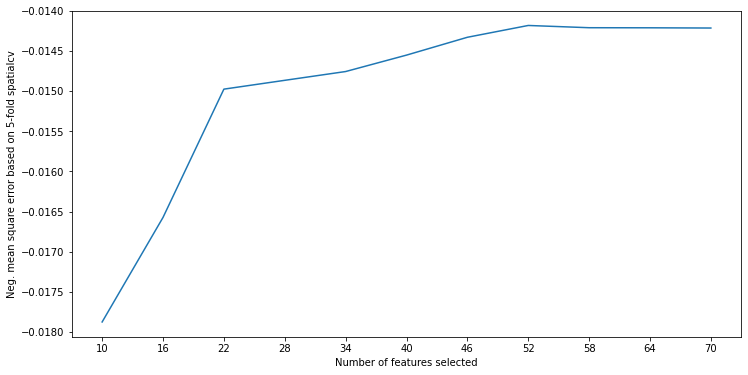

In [40]:
import matplotlib.pyplot as plt

rfecv_step = 6  #rfecv_step = int(len(covs) * 0.1)
rfecv_min_features_to_select = 10

plt.figure(figsize=(12,6))
plt.xlabel("Number of features selected")
plt.ylabel("Neg. mean square error based on 5-fold spatialcv")
plt.plot(range(rfecv_min_features_to_select, len(feat_cols)+rfecv_step, rfecv_step), rfecv_mean_score)
plt.xticks(range(rfecv_min_features_to_select, len(feat_cols)+rfecv_step, rfecv_step))
plt.show()